In [1]:
pip install pandas 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install fitter

  Using cached fitter-1.7.1-py3-none-any.whl.metadata (8.2 kB)
  Using cached loguru-0.7.3-py3-none-any.whl.metadata (22 kB)
  Using cached win32_setctime-1.2.0-py3-none-any.whl.metadata (2.4 kB)
Using cached fitter-1.7.1-py3-none-any.whl (26 kB)
Using cached loguru-0.7.3-py3-none-any.whl (61 kB)
Using cached win32_setctime-1.2.0-py3-none-any.whl (4.1 kB)
Note: you may need to restart the kernel to use updated packages.


basic description of german credit risk dataset


In [4]:
import pandas as pd 
import seaborn as sns


In [14]:

df = pd.read_csv(r"C:\Users\Danch\PycharmProjects\Credit_Scoring_Model_w_transformers\backend\datasets\german_credit_risk\german_credit_risk.csv")
df.head(10)

,Unnamed: 0,status_existing_checking,duration_month,credit_history,purpose,credit_amount,savings,employment,installment_rate,personal_status_sex,...,property,age,other_installment_plans,housing,existing_credits,job,people_liable,telephone,foreign_worker,target
0,0,A11,6,A34,A43,1169,A65,A75,4,A93,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,1,A12,48,A32,A43,5951,A61,A73,2,A92,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,2,A14,12,A34,A46,2096,A61,A74,2,A93,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,3,A11,42,A32,A42,7882,A61,A74,2,A93,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,4,A11,24,A33,A40,4870,A61,A73,3,A93,...,A124,53,A143,A153,2,A173,2,A191,A201,2
5,5,A14,36,A32,A46,9055,A65,A73,2,A93,...,A124,35,A143,A153,1,A172,2,A192,A201,1
6,6,A14,24,A32,A42,2835,A63,A75,3,A93,...,A122,53,A143,A152,1,A173,1,A191,A201,1
7,7,A12,36,A32,A41,6948,A61,A73,2,A93,...,A123,35,A143,A151,1,A174,1,A192,A201,1
8,8,A14,12,A32,A43,3059,A64,A74,2,A91,...,A121,61,A143,A152,1,A172,1,A191,A201,1
9,9,A12,30,A34,A40,5234,A61,A71,4,A94,...,A123,28,A143,A152,2,A174,1,A191,A201,2


check distribution of target column

In [15]:
df["target"].value_counts()

target
1    700
2    300
Name: count, dtype: int64

In [16]:
df["credit_amount"].describe()


count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: credit_amount, dtype: float64

Skewness: 1.946702018941924
Kurtosis: 4.265163377213492


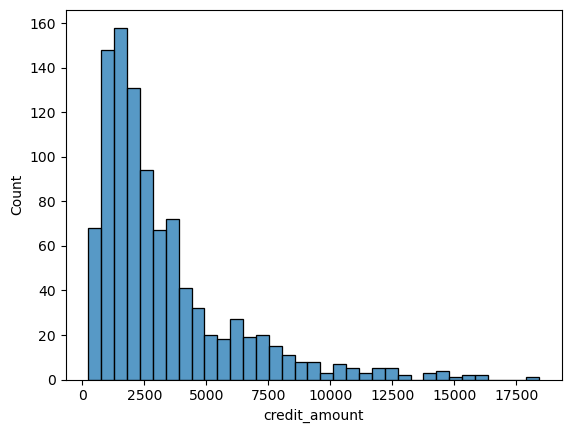

In [32]:
sns.histplot(df["credit_amount"])
print("Skewness:", skew(df["credit_amount"]))
print("Kurtosis:", kurtosis(df["credit_amount"]))

так как Skewness = 1.94 — сильно положительная асимметрия. и Kurtosis = 4.265 → "тяжёлые хвосты" и высокий пик. Для решения проблемы - можно применить логарифм данного значения. Тут он является довольно важным. Перед обработкой - можно построить бейзлайн модель без каких либо преобразований и фичи инжениринга и посмотреть на важность фичей, чтобы оценить какие из фичей дают наибольший вклад в модели 

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, chi2_contingency
import numpy as np

In [19]:
def detect_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = ((series < lower) | (series > upper)).sum()
    return {"iqr_low": lower, "iqr_high": upper, "outliers": int(outliers)}

In [20]:
def calc_woe_iv(df, feature, target="target"):
    tmp = df[[feature, target]].copy()
    tmp["cnt"] = 1

    grouped = tmp.groupby(feature).agg(
        good = (target, lambda x: (x == 0).sum()),
        bad  = (target, lambda x: (x == 1).sum()),
    )

    grouped["dist_good"] = grouped["good"] / grouped["good"].sum()
    grouped["dist_bad"]  = grouped["bad"] / grouped["bad"].sum()
    grouped["woe"] = np.log((grouped["dist_good"] + 1e-6) /
                            (grouped["dist_bad"] + 1e-6))
    grouped["iv"] = (grouped["dist_good"] - grouped["dist_bad"]) * grouped["woe"]

    return grouped.sort_values("iv", ascending=False)

In [40]:
def explore_feature(df, col, target="target"):
    print("="*80)
    print(f"FEATURE: {col}")
    print("="*80)
    print()

    series = df[col]

    # ------------------------------------------
    # Basic info
    # ------------------------------------------
    print("Type:", series.dtype)
    print("Unique values:", series.nunique())
    print("Missing:", series.isna().sum())
    print()

    # ------------------------------------------
    # Distribution
    # ------------------------------------------
    if series.dtype != "object":
        sns.histplot(series, kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()

        print("Skewness:", skew(series))
        print("Kurtosis:", kurtosis(series))
        print("discribe")
        print(series.describe())

        # Outliers
        out = detect_outliers(series)
        print("Outliers:", out)
        print()
    else:
        plt.figure(figsize=(10,4))
        series.value_counts().plot(kind="bar")
        plt.title(f"Category distribution: {col}")
        plt.show()

        # Rare categories
        rare = series.value_counts(normalize=True)[lambda x: x < 0.03]
        if len(rare) > 0:
            print("Rare categories (<3%):")
            print(rare)
            print()

    # ------------------------------------------
    # Relation to target
    # ------------------------------------------
    print("Relation to target:")

    if series.dtype != "object":
        sns.boxplot(x=df[target], y=series)
        plt.title(f"{col} vs {target}")
        plt.show()
    else:
        pivot = df.groupby(col)[target].mean().sort_values()
        print("Target rate per category:")
        print(pivot)
        print()

        # chi-square
        contingency = pd.crosstab(df[col], df[target])
        chi2, p, _, _ = chi2_contingency(contingency)
        print(f"Chi-square p-value: {p:.6f}")
        print()

    # ------------------------------------------
    # WOE / IV (only for categorical)
    # ------------------------------------------
    if series.dtype == "object":
        iv_table = calc_woe_iv(df, col, target)
        print("WOE / IV:")
        print(iv_table)
        print(f"IV total: {iv_table['iv'].sum():.4f}")
        print()



In [41]:
def explore_dataset(df, target="target"):
    """
    Run EDA for each column.
    """
    for col in df.columns:
        if col == target:
            continue
        explore_feature(df, col, target)

FEATURE: Unnamed: 0

Type: int64
Unique values: 1000
Missing: 0



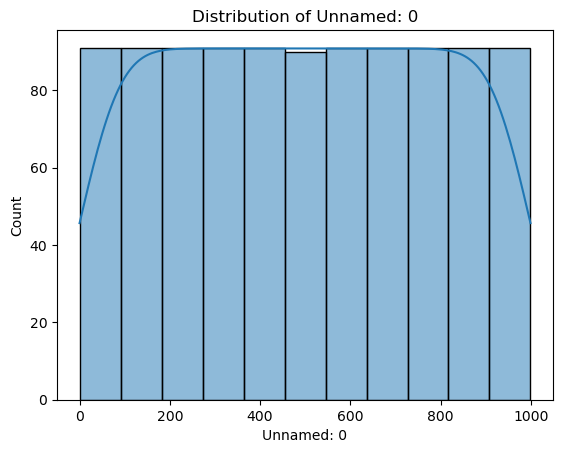

Skewness: 0.0
Kurtosis: -1.2000024000024
discribe
count    1000.000000
mean      499.500000
std       288.819436
min         0.000000
25%       249.750000
50%       499.500000
75%       749.250000
max       999.000000
Name: Unnamed: 0, dtype: float64
Outliers: {'iqr_low': -499.5, 'iqr_high': 1498.5, 'outliers': 0}

Relation to target:


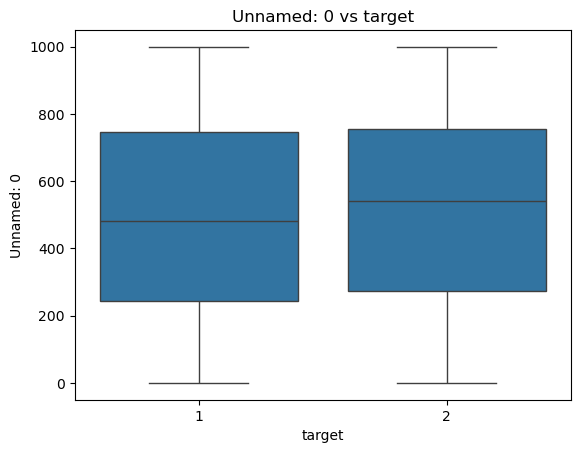

FEATURE: status_existing_checking

Type: object
Unique values: 4
Missing: 0



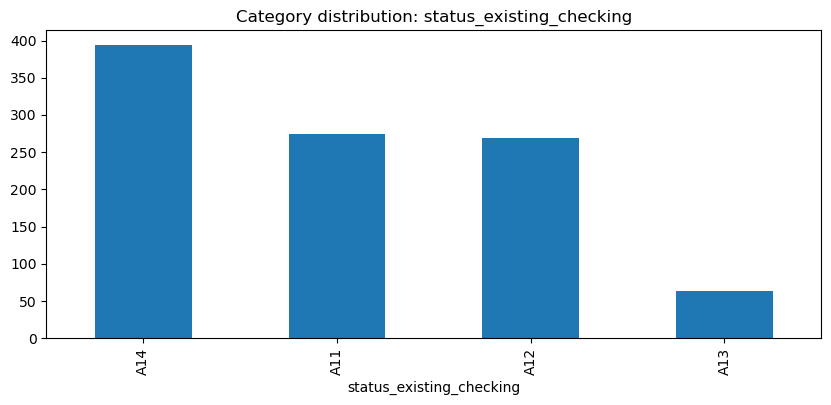

Relation to target:
Target rate per category:
status_existing_checking
A14    1.116751
A13    1.222222
A12    1.390335
A11    1.492701
Name: target, dtype: float64

Chi-square p-value: 0.000000

WOE / IV:
                          good  bad  dist_good  dist_bad  woe  iv
status_existing_checking                                         
A11                          0  139        NaN  0.198571  NaN NaN
A12                          0  164        NaN  0.234286  NaN NaN
A13                          0   49        NaN  0.070000  NaN NaN
A14                          0  348        NaN  0.497143  NaN NaN
IV total: 0.0000

FEATURE: duration_month

Type: int64
Unique values: 33
Missing: 0



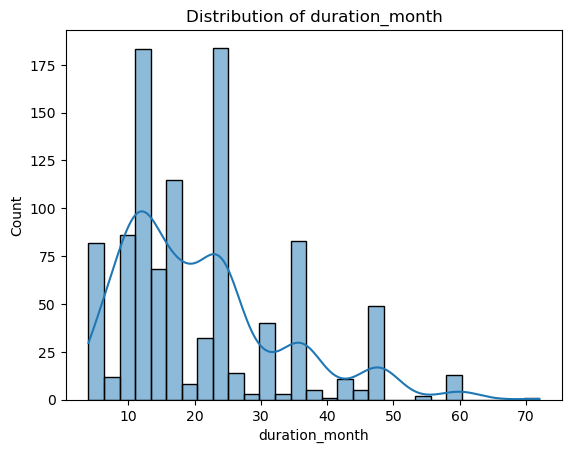

Skewness: 1.0925422109540106
Kurtosis: 0.9091948811374047
discribe
count    1000.000000
mean       20.903000
std        12.058814
min         4.000000
25%        12.000000
50%        18.000000
75%        24.000000
max        72.000000
Name: duration_month, dtype: float64
Outliers: {'iqr_low': -6.0, 'iqr_high': 42.0, 'outliers': 70}

Relation to target:


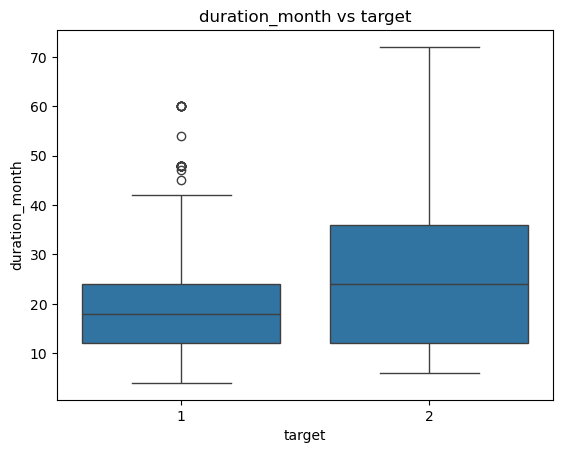

FEATURE: credit_history

Type: object
Unique values: 5
Missing: 0



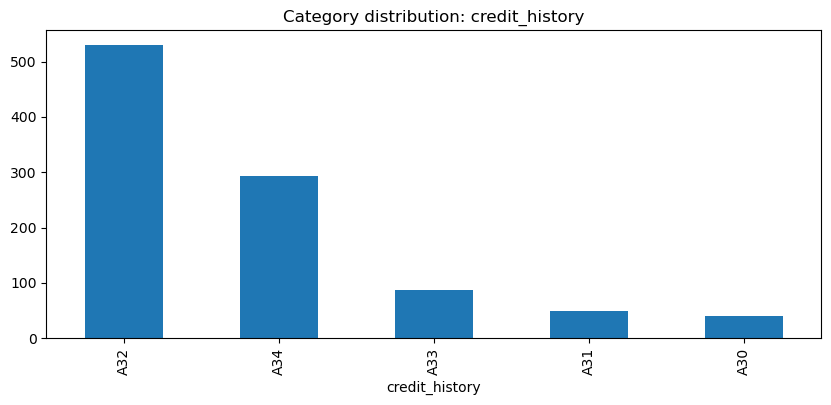

Relation to target:
Target rate per category:
credit_history
A34    1.170648
A33    1.318182
A32    1.318868
A31    1.571429
A30    1.625000
Name: target, dtype: float64

Chi-square p-value: 0.000000

WOE / IV:
                good  bad  dist_good  dist_bad  woe  iv
credit_history                                         
A30                0   15        NaN  0.021429  NaN NaN
A31                0   21        NaN  0.030000  NaN NaN
A32                0  361        NaN  0.515714  NaN NaN
A33                0   60        NaN  0.085714  NaN NaN
A34                0  243        NaN  0.347143  NaN NaN
IV total: 0.0000

FEATURE: purpose

Type: object
Unique values: 10
Missing: 0



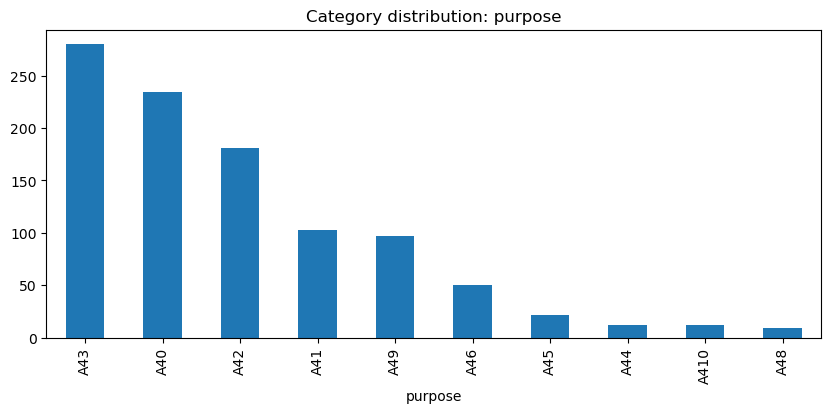

Rare categories (<3%):
purpose
A45     0.022
A44     0.012
A410    0.012
A48     0.009
Name: proportion, dtype: float64

Relation to target:
Target rate per category:
purpose
A48     1.111111
A41     1.165049
A43     1.221429
A42     1.320442
A44     1.333333
A49     1.350515
A45     1.363636
A40     1.380342
A410    1.416667
A46     1.440000
Name: target, dtype: float64

Chi-square p-value: 0.000116

WOE / IV:
         good  bad  dist_good  dist_bad  woe  iv
purpose                                         
A40         0  145        NaN  0.207143  NaN NaN
A41         0   86        NaN  0.122857  NaN NaN
A410        0    7        NaN  0.010000  NaN NaN
A42         0  123        NaN  0.175714  NaN NaN
A43         0  218        NaN  0.311429  NaN NaN
A44         0    8        NaN  0.011429  NaN NaN
A45         0   14        NaN  0.020000  NaN NaN
A46         0   28        NaN  0.040000  NaN NaN
A48         0    8        NaN  0.011429  NaN NaN
A49         0   63        NaN  0.090000  NaN N

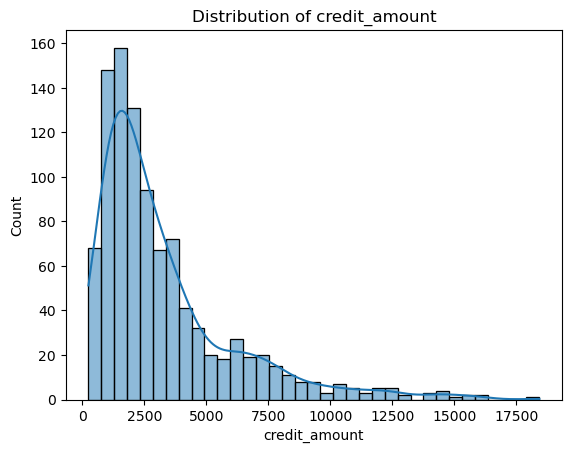

Skewness: 1.946702018941924
Kurtosis: 4.265163377213492
discribe
count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: credit_amount, dtype: float64
Outliers: {'iqr_low': -2544.625, 'iqr_high': 7882.375, 'outliers': 72}

Relation to target:


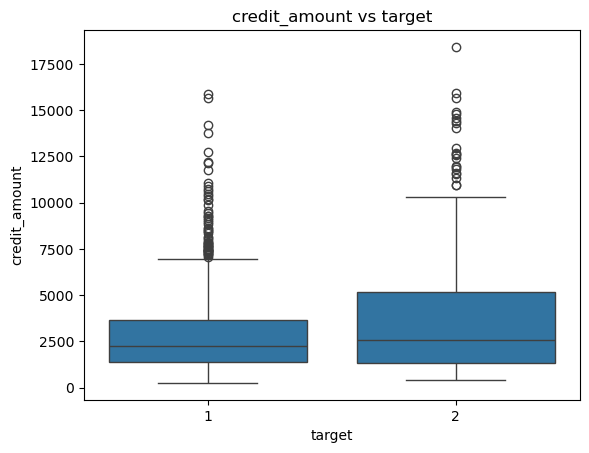

FEATURE: savings

Type: object
Unique values: 5
Missing: 0



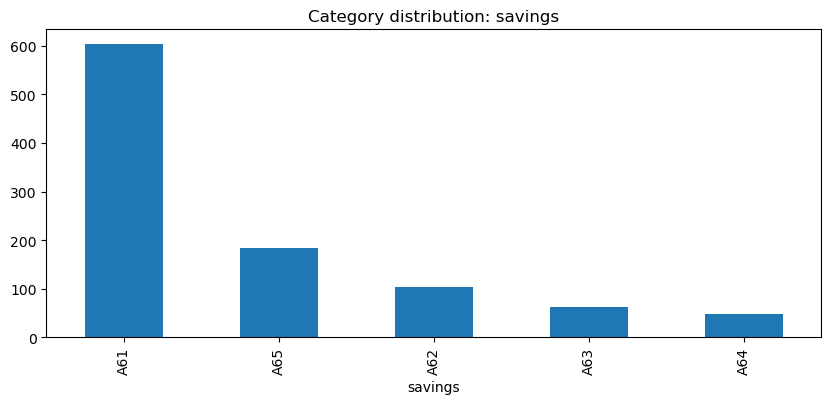

Relation to target:
Target rate per category:
savings
A64    1.125000
A63    1.174603
A65    1.174863
A62    1.330097
A61    1.359867
Name: target, dtype: float64

Chi-square p-value: 0.000000

WOE / IV:
         good  bad  dist_good  dist_bad  woe  iv
savings                                         
A61         0  386        NaN  0.551429  NaN NaN
A62         0   69        NaN  0.098571  NaN NaN
A63         0   52        NaN  0.074286  NaN NaN
A64         0   42        NaN  0.060000  NaN NaN
A65         0  151        NaN  0.215714  NaN NaN
IV total: 0.0000

FEATURE: employment

Type: object
Unique values: 5
Missing: 0



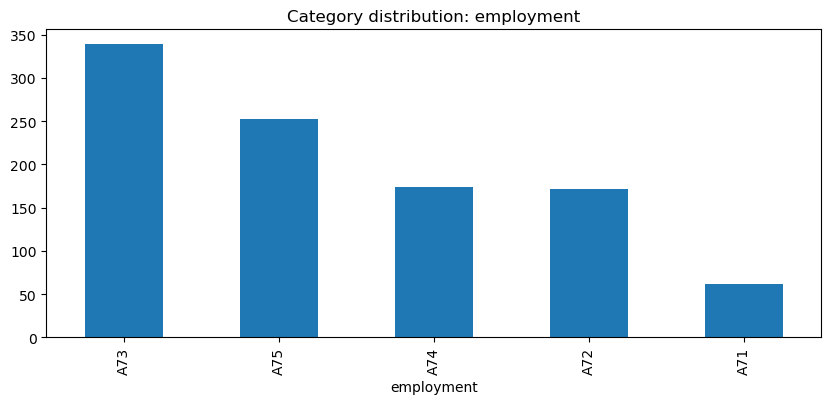

Relation to target:
Target rate per category:
employment
A74    1.224138
A75    1.252964
A73    1.306785
A71    1.370968
A72    1.406977
Name: target, dtype: float64

Chi-square p-value: 0.001045

WOE / IV:
            good  bad  dist_good  dist_bad  woe  iv
employment                                         
A71            0   39        NaN  0.055714  NaN NaN
A72            0  102        NaN  0.145714  NaN NaN
A73            0  235        NaN  0.335714  NaN NaN
A74            0  135        NaN  0.192857  NaN NaN
A75            0  189        NaN  0.270000  NaN NaN
IV total: 0.0000

FEATURE: installment_rate

Type: int64
Unique values: 4
Missing: 0



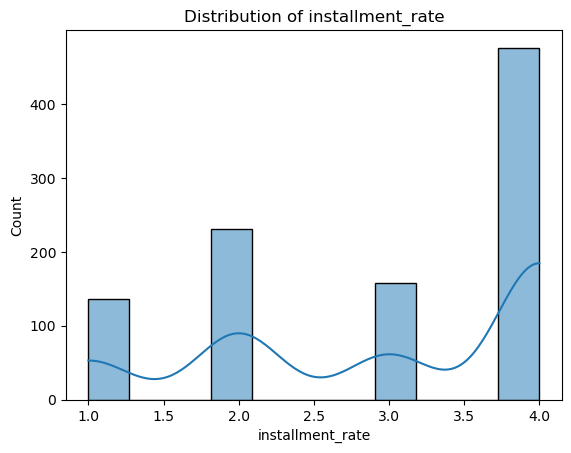

Skewness: -0.5305507598158565
Kurtosis: -1.2104232256102134
discribe
count    1000.000000
mean        2.973000
std         1.118715
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: installment_rate, dtype: float64
Outliers: {'iqr_low': -1.0, 'iqr_high': 7.0, 'outliers': 0}

Relation to target:


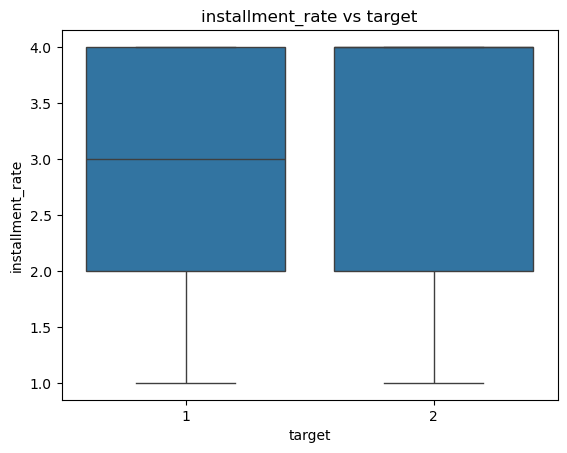

FEATURE: personal_status_sex

Type: object
Unique values: 4
Missing: 0



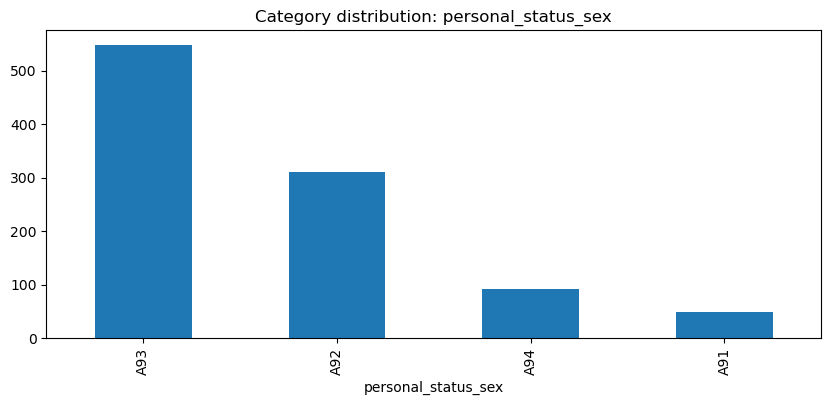

Relation to target:
Target rate per category:
personal_status_sex
A93    1.266423
A94    1.271739
A92    1.351613
A91    1.400000
Name: target, dtype: float64

Chi-square p-value: 0.022238

WOE / IV:
                     good  bad  dist_good  dist_bad  woe  iv
personal_status_sex                                         
A91                     0   30        NaN  0.042857  NaN NaN
A92                     0  201        NaN  0.287143  NaN NaN
A93                     0  402        NaN  0.574286  NaN NaN
A94                     0   67        NaN  0.095714  NaN NaN
IV total: 0.0000

FEATURE: other_debtors

Type: object
Unique values: 3
Missing: 0



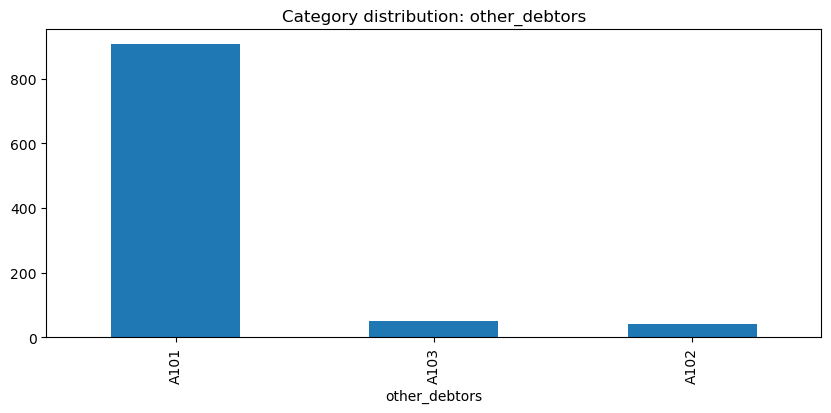

Relation to target:
Target rate per category:
other_debtors
A103    1.192308
A101    1.299890
A102    1.439024
Name: target, dtype: float64

Chi-square p-value: 0.036056

WOE / IV:
               good  bad  dist_good  dist_bad  woe  iv
other_debtors                                         
A101              0  635        NaN  0.907143  NaN NaN
A102              0   23        NaN  0.032857  NaN NaN
A103              0   42        NaN  0.060000  NaN NaN
IV total: 0.0000

FEATURE: residence_since

Type: int64
Unique values: 4
Missing: 0



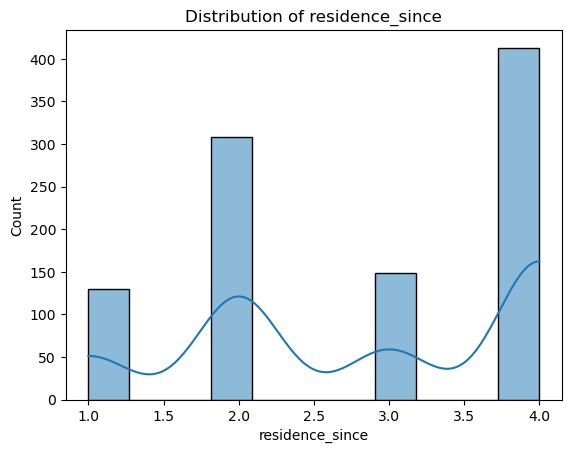

Skewness: -0.27216078883719325
Kurtosis: -1.3805449294715695
discribe
count    1000.000000
mean        2.845000
std         1.103718
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: residence_since, dtype: float64
Outliers: {'iqr_low': -1.0, 'iqr_high': 7.0, 'outliers': 0}

Relation to target:


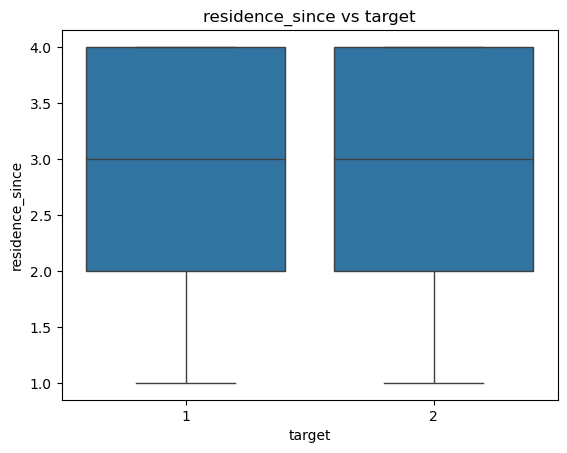

FEATURE: property

Type: object
Unique values: 4
Missing: 0



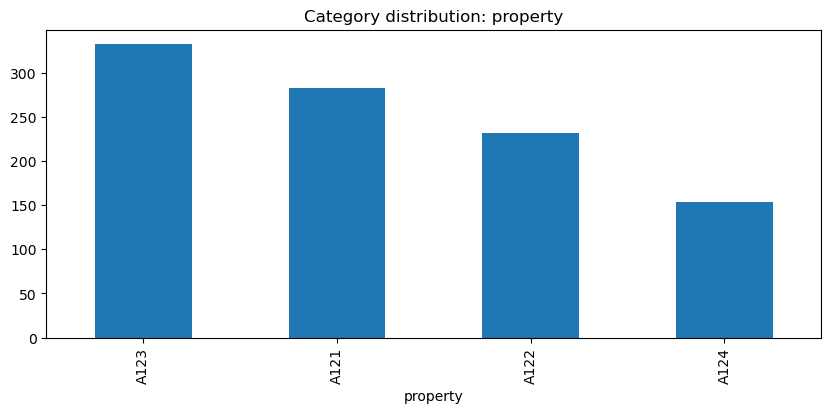

Relation to target:
Target rate per category:
property
A121    1.212766
A122    1.306034
A123    1.307229
A124    1.435065
Name: target, dtype: float64

Chi-square p-value: 0.000029

WOE / IV:
          good  bad  dist_good  dist_bad  woe  iv
property                                         
A121         0  222        NaN  0.317143  NaN NaN
A122         0  161        NaN  0.230000  NaN NaN
A123         0  230        NaN  0.328571  NaN NaN
A124         0   87        NaN  0.124286  NaN NaN
IV total: 0.0000

FEATURE: age

Type: int64
Unique values: 53
Missing: 0



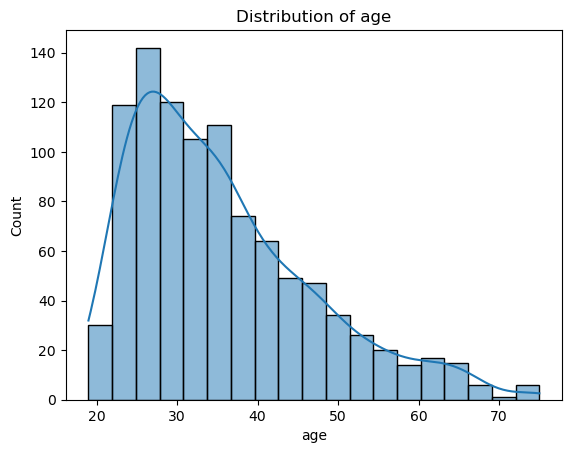

Skewness: 1.019207521364841
Kurtosis: 0.5868108307295379
discribe
count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: age, dtype: float64
Outliers: {'iqr_low': 4.5, 'iqr_high': 64.5, 'outliers': 23}

Relation to target:


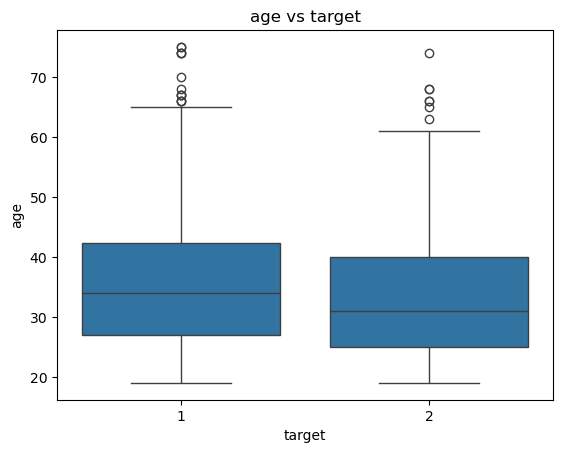

FEATURE: other_installment_plans

Type: object
Unique values: 3
Missing: 0



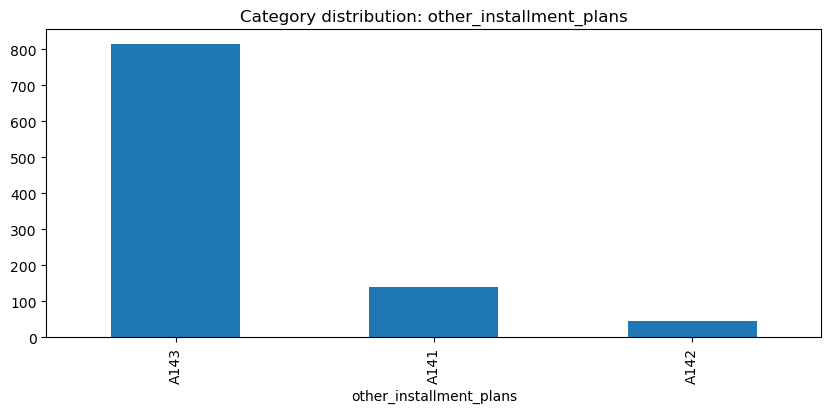

Relation to target:
Target rate per category:
other_installment_plans
A143    1.275184
A142    1.404255
A141    1.410072
Name: target, dtype: float64

Chi-square p-value: 0.001629

WOE / IV:
                         good  bad  dist_good  dist_bad  woe  iv
other_installment_plans                                         
A141                        0   82        NaN  0.117143  NaN NaN
A142                        0   28        NaN  0.040000  NaN NaN
A143                        0  590        NaN  0.842857  NaN NaN
IV total: 0.0000

FEATURE: housing

Type: object
Unique values: 3
Missing: 0



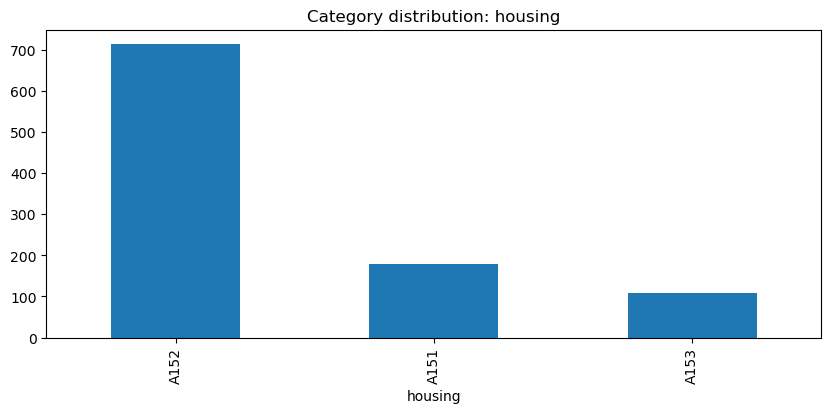

Relation to target:
Target rate per category:
housing
A152    1.260870
A151    1.391061
A153    1.407407
Name: target, dtype: float64

Chi-square p-value: 0.000112

WOE / IV:
         good  bad  dist_good  dist_bad  woe  iv
housing                                         
A151        0  109        NaN  0.155714  NaN NaN
A152        0  527        NaN  0.752857  NaN NaN
A153        0   64        NaN  0.091429  NaN NaN
IV total: 0.0000

FEATURE: existing_credits

Type: int64
Unique values: 4
Missing: 0



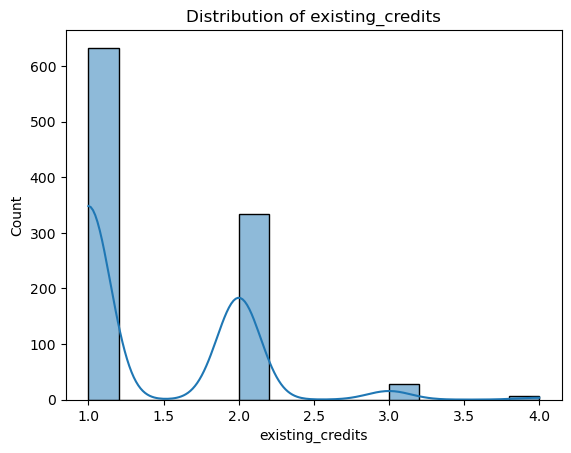

Skewness: 1.2706663071344104
Kurtosis: 1.59043439263285
discribe
count    1000.000000
mean        1.407000
std         0.577654
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: existing_credits, dtype: float64
Outliers: {'iqr_low': -0.5, 'iqr_high': 3.5, 'outliers': 6}

Relation to target:


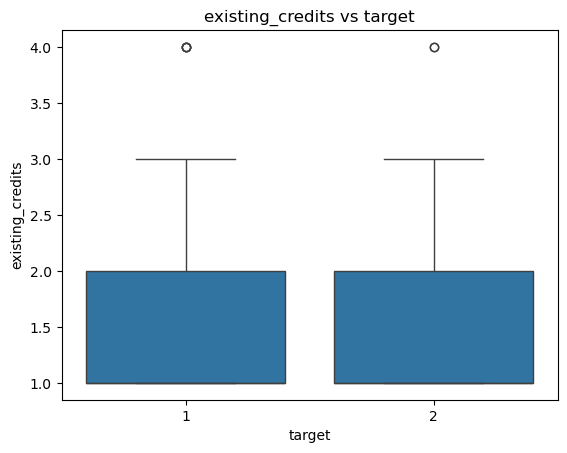

FEATURE: job

Type: object
Unique values: 4
Missing: 0



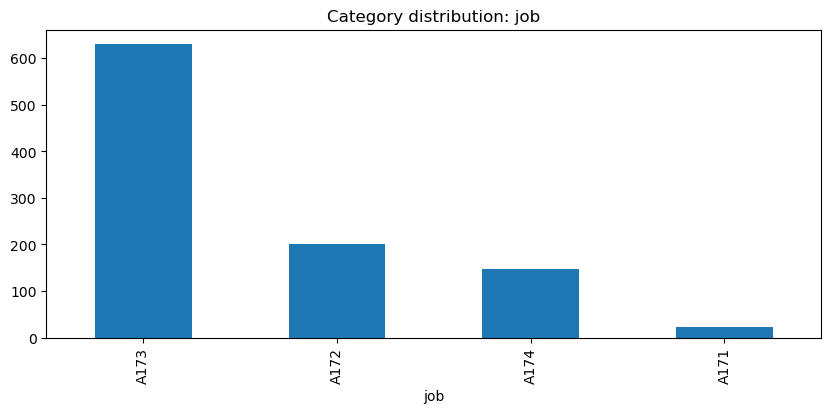

Rare categories (<3%):
job
A171    0.022
Name: proportion, dtype: float64

Relation to target:
Target rate per category:
job
A172    1.280000
A173    1.295238
A171    1.318182
A174    1.344595
Name: target, dtype: float64

Chi-square p-value: 0.596582

WOE / IV:
      good  bad  dist_good  dist_bad  woe  iv
job                                          
A171     0   15        NaN  0.021429  NaN NaN
A172     0  144        NaN  0.205714  NaN NaN
A173     0  444        NaN  0.634286  NaN NaN
A174     0   97        NaN  0.138571  NaN NaN
IV total: 0.0000

FEATURE: people_liable

Type: int64
Unique values: 2
Missing: 0



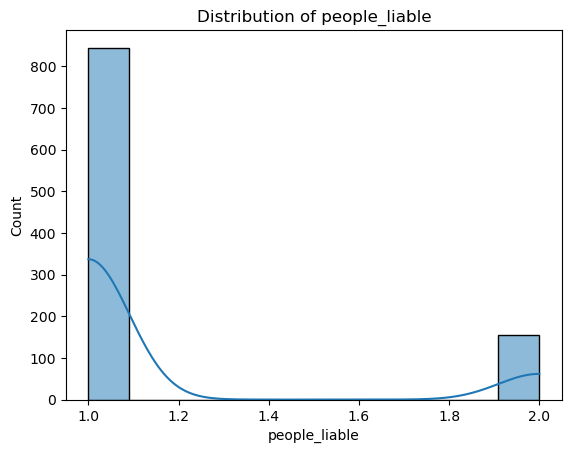

Skewness: 1.9065793599765346
Kurtosis: 1.6350448558885295
discribe
count    1000.000000
mean        1.155000
std         0.362086
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: people_liable, dtype: float64
Outliers: {'iqr_low': 1.0, 'iqr_high': 1.0, 'outliers': 155}

Relation to target:


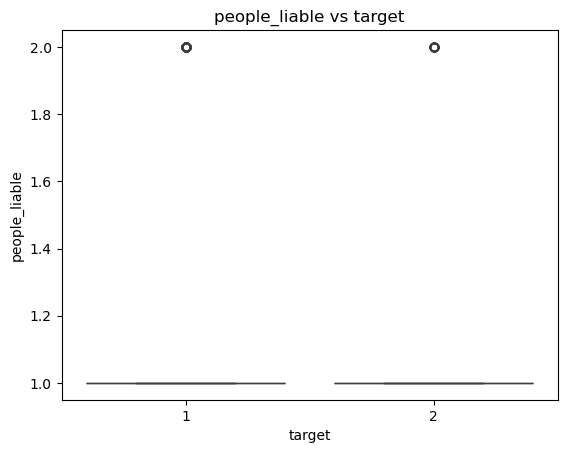

FEATURE: telephone

Type: object
Unique values: 2
Missing: 0



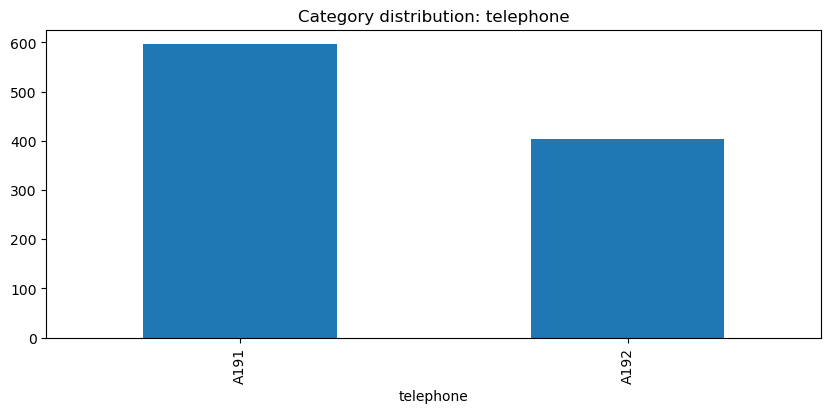

Relation to target:
Target rate per category:
telephone
A192    1.279703
A191    1.313758
Name: target, dtype: float64

Chi-square p-value: 0.278876

WOE / IV:
           good  bad  dist_good  dist_bad  woe  iv
telephone                                         
A191          0  409        NaN  0.584286  NaN NaN
A192          0  291        NaN  0.415714  NaN NaN
IV total: 0.0000

FEATURE: foreign_worker

Type: object
Unique values: 2
Missing: 0



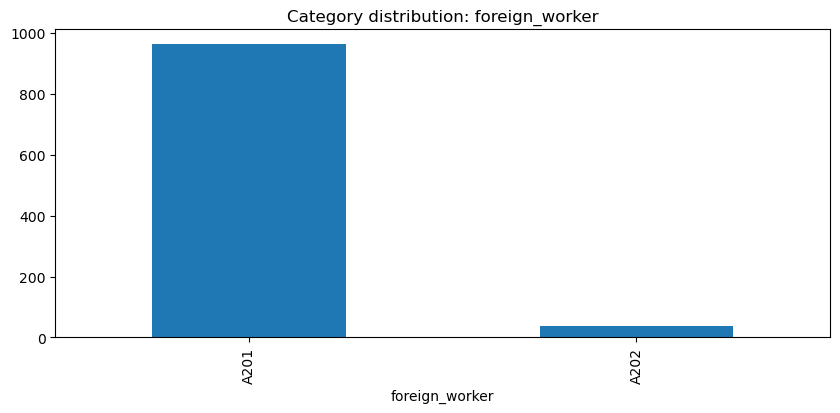

Relation to target:
Target rate per category:
foreign_worker
A202    1.108108
A201    1.307373
Name: target, dtype: float64

Chi-square p-value: 0.015831

WOE / IV:
                good  bad  dist_good  dist_bad  woe  iv
foreign_worker                                         
A201               0  667        NaN  0.952857  NaN NaN
A202               0   33        NaN  0.047143  NaN NaN
IV total: 0.0000



In [42]:
explore_dataset(df)

In [43]:
def plot_correlation(df, threshold=0.7):
    # Убираем target
    df_corr = df.drop(columns=["target"], errors='ignore')

    # Берём только числовые признаки
    num_cols = df_corr.select_dtypes(include=["int64", "float64"]).columns

    corr = df_corr[num_cols].corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
    plt.title("Correlation matrix (numerical features)")
    plt.show()

    # Фильтр сильных корреляций
    high_corr = []
    for i in range(len(num_cols)):
        for j in range(i+1, len(num_cols)):
            if abs(corr.iloc[i,j]) > threshold:
                high_corr.append((num_cols[i], num_cols[j], corr.iloc[i,j]))

    return sorted(high_corr, key=lambda x: -abs(x[2]))

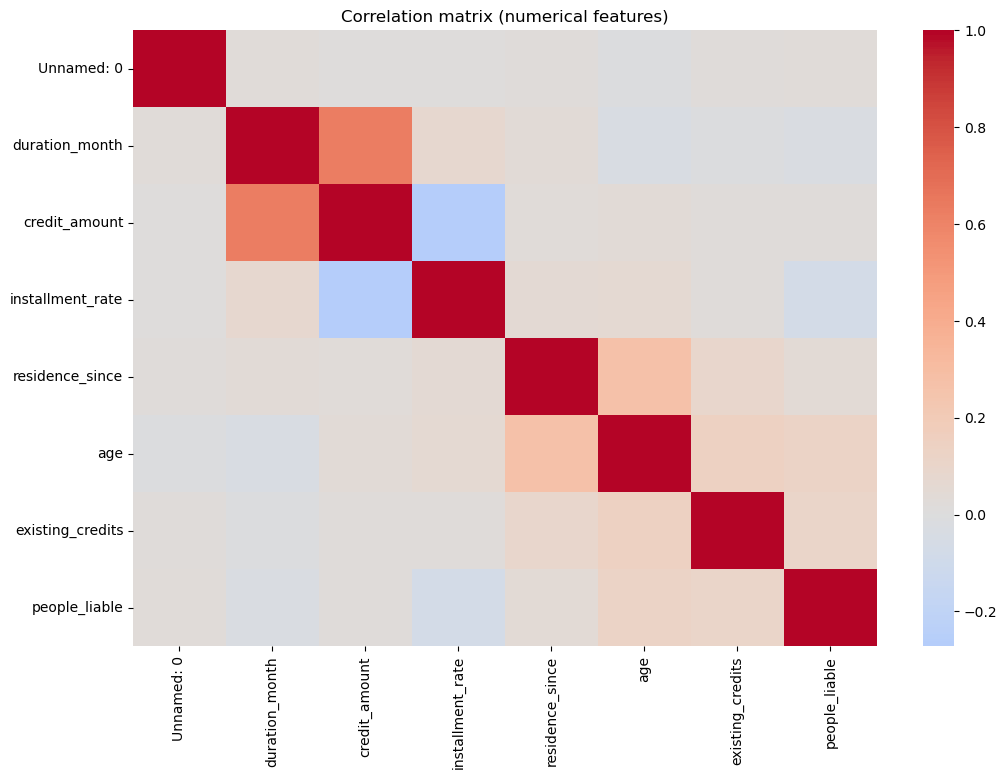

[]

In [44]:
high_corr = plot_correlation(df)
high_corr

In [45]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    r_corr = r - (r-1)**2/(n-1)
    k_corr = k - (k-1)**2/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

In [27]:
def categorical_correlations(df):
    cat_cols = df.drop(columns=["target"], errors="ignore").select_dtypes(include="object").columns
    result = []

    for i in range(len(cat_cols)):
        for j in range(i+1, len(cat_cols)):
            cm = pd.crosstab(df[cat_cols[i]], df[cat_cols[j]])
            v = cramers_v(cm.values)
            result.append((cat_cols[i], cat_cols[j], v))

    return sorted(result, key=lambda x: -x[2])

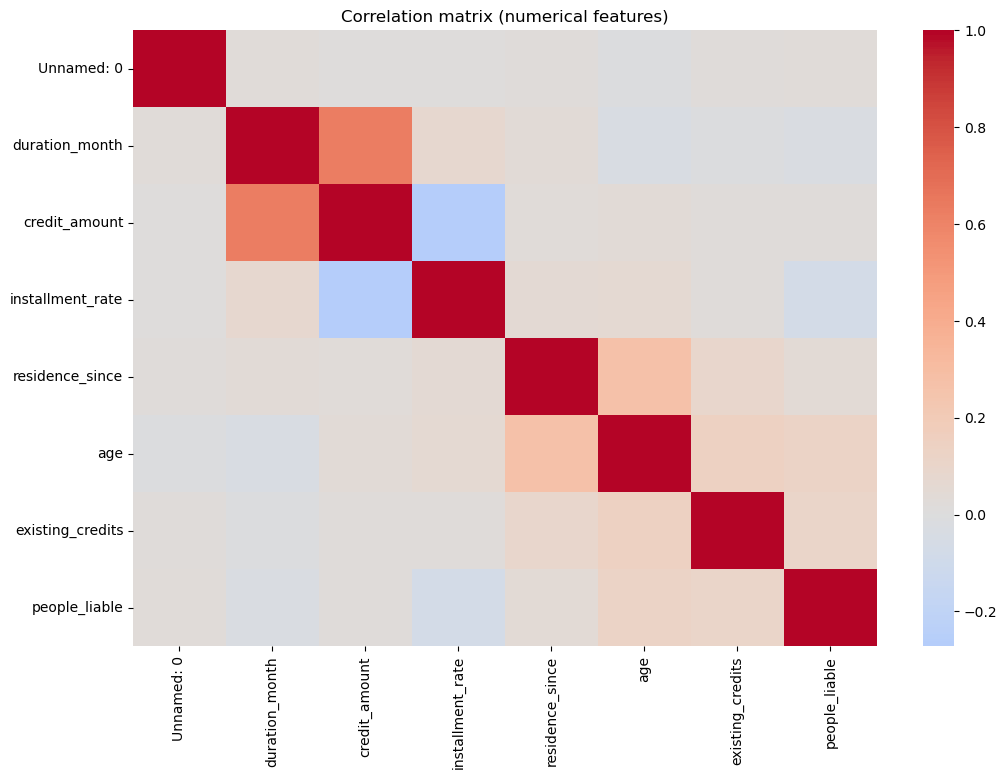

([],
 [('property', 'housing', 0.5510116404863402),
  ('job', 'telephone', 0.42236303561005084),
  ('employment', 'job', 0.30527183511097006),
  ('credit_history', 'other_installment_plans', 0.20606871117992548),
  ('purpose', 'telephone', 0.19926318777409202),
  ('personal_status_sex', 'housing', 0.1947916457256411),
  ('property', 'telephone', 0.19015821615429923),
  ('purpose', 'housing', 0.18770384992034497),
  ('property', 'job', 0.18627995763040348),
  ('purpose', 'property', 0.18289970189960558),
  ('purpose', 'job', 0.17953734765708307),
  ('status_existing_checking', 'savings', 0.1640158753844637),
  ('employment', 'housing', 0.16109732636497048),
  ('employment', 'personal_status_sex', 0.15388862974109566),
  ('credit_history', 'purpose', 0.13781225809819178),
  ('employment', 'telephone', 0.1367067887923341),
  ('purpose', 'foreign_worker', 0.1362432205086601),
  ('purpose', 'other_debtors', 0.13542266825612073),
  ('employment', 'property', 0.13302290838651426),
  ('propert

In [28]:
high_corr_num = plot_correlation(df)
high_corr_cat = categorical_correlations(df)

high_corr_num, high_corr_cat

In [29]:
def plot_correlation_without_target(df, threshold=0.7):
    # Убираем target
    df_corr = df

    # Берём только числовые признаки
    num_cols = df_corr.select_dtypes(include=["int64", "float64"]).columns

    corr = df_corr[num_cols].corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
    plt.title("Correlation matrix (numerical features)")
    plt.show()

    # Фильтр сильных корреляций
    high_corr = []
    for i in range(len(num_cols)):
        for j in range(i+1, len(num_cols)):
            if abs(corr.iloc[i,j]) > threshold:
                high_corr.append((num_cols[i], num_cols[j], corr.iloc[i,j]))

    return sorted(high_corr, key=lambda x: -abs(x[2]))

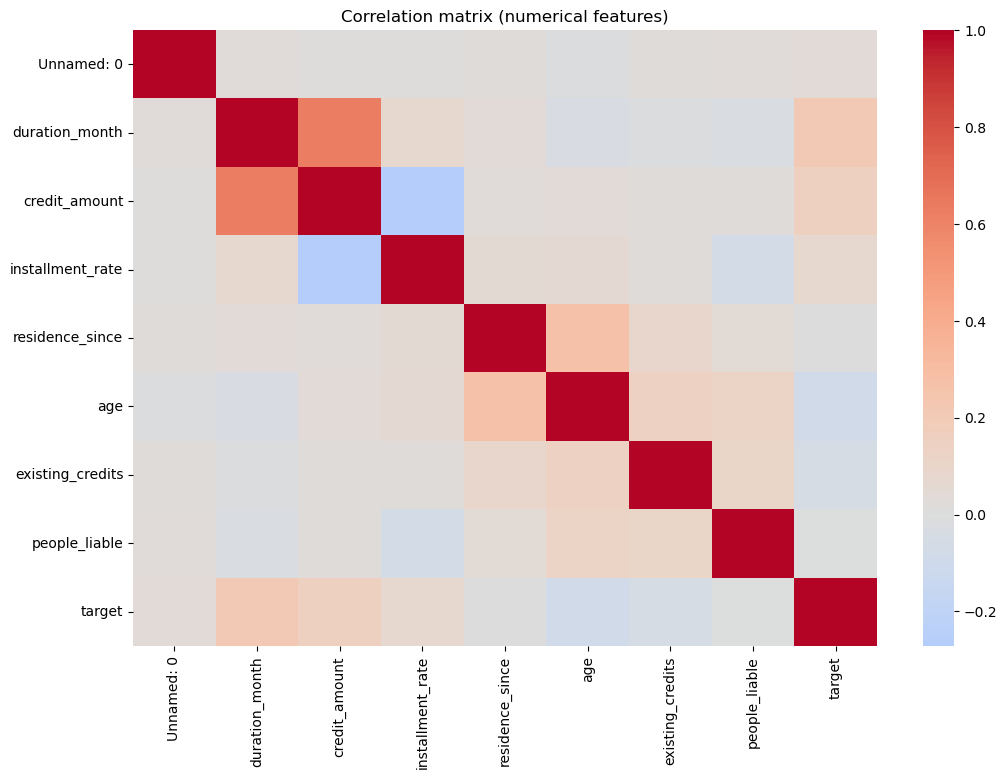

In [30]:
high_corr_num = plot_correlation_without_target(df)